In [1]:
from drn_interactions.interactions.loaders import BaseShockSlowInteractionsLoader
from drn_interactions.transforms.spikes import SpikesHandlerMulti, SpikesHandler
from drn_interactions.interactions.preprocessors import InteractionsPreprocessor
from drn_interactions.interactions.pairwise import PairwiseCorr
from drn_interactions.interactions.graph_clustering import df_to_graph
from drn_interactions.plots.heatmaps import state_indicator
from drn_interactions.decoding.loaders import StateDecodeDataLoader
from drn_interactions.decoding.preprocessors import StateDecodePreprocessor
from drn_interactions.config import ExperimentInfo
from drn_interactions.io import load_derived_generic, load_distances
from drn_interactions.transforms.graph import GraphTransformer
from drn_interactions.transforms.spikes import SpikesHandler
from sklearn.preprocessing import minmax_scale, robust_scale
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.ndimage import gaussian_filter1d, median_filter
from drn_interactions.config import Config
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from typing import Sequence
from sklearn.preprocessing import LabelEncoder

sns.set_theme(style="ticks", context="paper")

In [2]:
class Loaders:
    def __init__(
        self,
        session_name,
        bin_width=1,
        gaussian_sigma=None,
        df_ensembles=None,
        ensemble_id_col: str = "ensemble_id",
        ensemble_labels=None,
        ensemble_ref_state: str = "pre",
        corr_fill_value=0,
        rev_order_spikes=True,
    ):
        self.session_name = session_name
        self.bin_width = bin_width
        self.gaussian_sigma = gaussian_sigma
        self.corr_fill_value = corr_fill_value
        self.rev_order_spikes = rev_order_spikes
        if df_ensembles is not None:
            self.neurons = df_ensembles.loc[
                lambda x: (x.session_name == session_name)
                & (x.block == ensemble_ref_state)
                & (x.bin_width == bin_width)
            ]
            self.neurons = self.neurons.sort_values(ensemble_id_col)["neuron_id"].values
        else:
            self.neurons = None

    def reorder_affinity(self, df_affinity: pd.DataFrame) -> pd.DataFrame:
        return df_affinity.reindex(index=self.neurons, columns=self.neurons, fill_value=self.corr_fill_value)

    def reorder_spikes(self, spikes: pd.DataFrame) -> pd.DataFrame:
        return spikes.reindex(columns=self.neurons)

    def _get_affinity(self, spikes: pd.DataFrame) -> pd.DataFrame:
        preprocessor = InteractionsPreprocessor(z=True)
        mod = PairwiseCorr(rectify=True)
        spikes = preprocessor(spikes)
        df_affinity = mod.fit(spikes).get_adjacency_df()
        if self.neurons is not None:
            return self.reorder_affinity(df_affinity)
        return df_affinity

    def preprocess_spikes(self, spikes: pd.DataFrame) -> pd.DataFrame:
        if self.gaussian_sigma is not None:
            spikes = spikes.transform(gaussian_filter1d, sigma=self.gaussian_sigma)
        vals = TfidfTransformer().fit_transform(spikes).todense()
        spikes = (
            pd.DataFrame(vals, columns=spikes.columns, index=spikes.index)
            .apply(minmax_scale)
        )
        return spikes
    
    def _get_spikes(
        self, t_start, t_stop, preprocess: bool = True,
    ) -> pd.DataFrame:
        loader = SpikesHandler(
            session_names=[self.session_name],
            block="base_shock",
            t_start=t_start,
            t_stop=t_stop,
            bin_width=self.bin_width,
        )
        spikes = loader.binned_piv
        if preprocess:
            spikes = self.preprocess_spikes(spikes)

        if self.neurons is not None:
            return self.reorder_spikes(spikes)
        return spikes

    def get_spikes_pre(
        self, preprocess: bool = True, t_start=-600, t_stop=0
    ) -> pd.DataFrame:
        return self._get_spikes(preprocess=preprocess, t_start=t_start, t_stop=t_stop)

    def get_spikes_shock(
        self, preprocess: bool = True, t_start=0, t_stop=600
    ) -> pd.DataFrame:
        return self._get_spikes(preprocess=preprocess, t_start=t_start, t_stop=t_stop)

    def get_spikes_all(
        self,  preprocess: bool = True, t_start=-600, t_stop=600
    ) -> pd.DataFrame:
        return self._get_spikes(preprocess=preprocess, t_start=t_start, t_stop=t_stop)

    def get_affinity_pre(self, preprocess=False, t_start=-600, t_stop=0):
        spikes = self._get_spikes(
            preprocess=preprocess,  t_start=t_start, t_stop=t_stop
        )
        df_affinity = self._get_affinity(spikes)
        return df_affinity

    def get_affinity_shock(self, preprocess=False, t_start=0, t_stop=600):
        spikes = self._get_spikes(
            preprocess=preprocess, t_start=t_start, t_stop=t_stop
        )
        df_affinity = self._get_affinity(spikes)
        return df_affinity

    def get_affinity_all(self, preprocess=False, t_start=-600, t_stop=600):
        spikes = self._get_spikes(
            preprocess=preprocess, t_start=t_start, t_stop=t_stop
        )
        df_affinity = self._get_affinity(spikes)
        return df_affinity


class Plotter:
    def __init__(
        self,
        corr_cmap="viridis",
        corr_vmin=0,
        corr_vmax=1,
        spikes_cmap="Greys",
        spikes_vmin=0,
        spikes_vmax=1,
    ):
        self.corr_cmap = corr_cmap
        self.corr_vmin = corr_vmin
        self.corr_vmax = corr_vmax
        self.spikes_cmap = spikes_cmap
        self.spikes_vmin = spikes_vmin
        self.spikes_vmax = spikes_vmax

    def plot_affinity(self, df_affinity: pd.DataFrame, ax: plt.Axes, **kwargs):
        sns.heatmap(
            df_affinity,
            cmap=self.corr_cmap,
            ax=ax,
            vmin=self.corr_vmin,
            vmax=self.corr_vmax,
            **kwargs
        )
        return ax

    def plot_spikes(self, spikes: pd.DataFrame, ax: plt.Axes, **kwargs):
        sns.heatmap(
            spikes.T,
            cmap=self.spikes_cmap,
            vmin=self.spikes_vmin,
            vmax=self.spikes_vmax,
            ax=ax,
            **kwargs
        )
        return ax


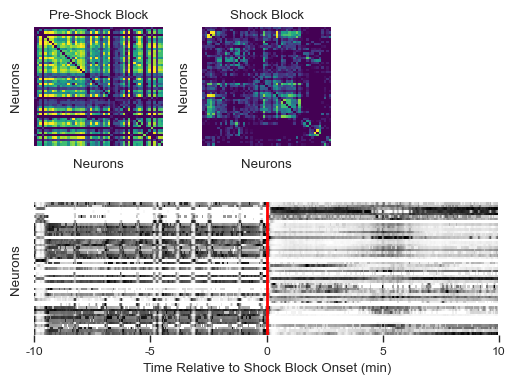

In [4]:
df_ensembles = (
    load_derived_generic("ensembles/fs - ensembles - true.csv")
    .loc[lambda x: x.bin_width == 1]
    .drop_duplicates()
)
sessions = df_ensembles.session_name.unique()


loader = Loaders(session_name=sessions[5], df_ensembles=df_ensembles, gaussian_sigma=2, ensemble_ref_state="base_shock")
plotter = Plotter(corr_vmax=0.7)

spikes = loader.get_spikes_all(preprocess=True, )
df_affinity_pre = loader.get_affinity_pre(preprocess=False)
df_affinity_shock = loader.get_affinity_shock(preprocess=False)


f = plt.figure(figsize=(6, 4))
axes = f.subplot_mosaic(
    [["A", "B", "."], ["C", "C", "C"]], 
    gridspec_kw=dict(height_ratios=[0.9, 1,], width_ratios=[1, 1, 1], wspace=0.3, hspace=0.45),
    )

plotter.plot_affinity(df_affinity_pre, axes["A"], cbar=False, xticklabels=[], yticklabels=[])
plotter.plot_affinity(df_affinity_shock, axes["B"], cbar=False, xticklabels=[], yticklabels=[])
plotter.plot_spikes(spikes, axes["C"], cbar=False, yticklabels=[])



axes["A"].set_title("Pre-Shock Block")
axes["A"].set_xlabel("Neurons")
axes["A"].set_ylabel("Neurons")

axes["B"].set_title("Shock Block")
axes["B"].set_xlabel("Neurons")
axes["B"].set_ylabel("Neurons")

axes["C"].set_xlabel("Time Relative to Shock Block Onset (min)")
axes["C"].set_ylabel("Neurons")
axes["C"].axvline(x=601, color="red", linewidth=2)
axes["C"].set_xlim(0, 1201)
axes["C"].xaxis.set_major_locator(plt.MultipleLocator(300))
axes["C"].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: int(x / 60) -10))
_ = plt.setp(axes["C"].xaxis.get_majorticklabels(), rotation=0)

f.savefig(Config.fig_dir / "fs - interactions - examples.png", bbox_inches="tight", dpi=300)